# Мультиколлинеарность и метод главных компонент

В этом задании требуется оценить модель, в которой присутствуют регрессоры с мультиколлинеарностью. Для решения используются штрафы в МНК (методы Лассо и Ридж).

Главная проблема: лассо- и ридж-регрессии работают по-разному в пакетах `statsmodels` и `sklearn`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
%matplotlib inline

Набор данных `airquality` из R. В наборе указаны данные по содержанию озона в воздухе, солнечной радиации, скорости ветра, температуре.

In [21]:
df = pd.read_csv('airquality.csv', index_col=0)
df.rename(columns={'Ozone':'ozone', 'Solar.R':'solar_rad', 'Wind':'wind', 'Temp':'temp', 'Month':'month', 'Day':'day'},
         inplace=True)
df.head()

,ozone,solar_rad,wind,temp,month,day
1,41,190,7.4,67,5,1
2,36,118,8.0,72,5,2
3,12,149,12.6,74,5,3
4,18,313,11.5,62,5,4
5,NaN,NaN,14.3,56,5,5


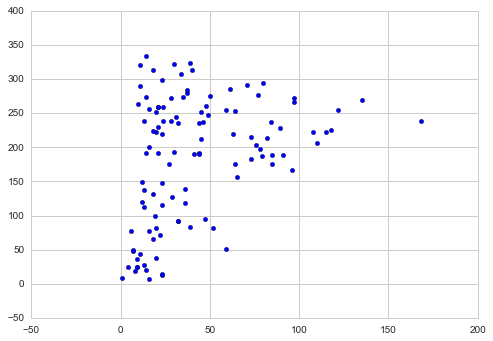

In [22]:
df.describe()
sns.set(style='whitegrid', context='notebook')
plt.scatter(df.ozone, df.solar_rad)

## Выявление мультиколлинеарности

Чтобы примерно оценить, есть ли мультиколлинеарность между регрессорами, можно вычислить параметры $VIF$. Для этого надо посчитать регрессию одного регрессора на остальные и вычислить значение $VIF_j = \frac{1}{1 - R_j^2}$. Если это значение получается большое (на глаз - больше 10), то это значит, что значение $R^2$ маленькое - и это может свидетельствовать о мультиколлинеарности.

Рассчитать VIF можно вручную, а можно воспользоваться функцией `statsmodels.stats.outliers_influence.variance_inflation_factor()`.

In [48]:
df = df.dropna()
cols = ['solar_rad','wind','temp']
model = sm.OLS(df.ozone, df[['solar_rad', 'wind', 'temp']])
res = model.fit()

for col in cols:
    regr = [i for i in cols if i != col]
    model_regr = sm.OLS(df[col], df[regr])
    r2 = model_regr.fit().rsquared
    print('VIF for %s = %.3f' % (col, round(1 / (1 - r2), 3)))

VIF for solar_rad = 5.624
VIF for wind = 6.135
VIF for temp = 10.918


In [50]:
from statsmodels import stats
cols = ['solar_rad', 'wind', 'temp']
X = df[cols].as_matrix()
for i in range(len(cols)):
    vif = stats.outliers_influence.variance_inflation_factor(X, i)
    print('VIF for %s = %.3f' % (cols[i], vif))

VIF for solar_rad = 5.624
VIF for wind = 6.135
VIF for temp = 10.918


## Обход мультиколлинеарности

Лассо- и ридж-регрессия, а также метод главных компонент реализованы в пакете `statsmodels` (см. ниже). Проблема в том, что результаты не совпадают с результатми работы аналогичных функций из пакета `sklearn`. Поскольку при отправке на курсеру решений, полученных в `statsmodels`, решение не было принято как правильное, то рискну предположить, что эти функции в `statsmodels` работают неудовлетворительно. Поэтому предлагается использовать их из `sklearn`.


**alpha** : *scalar or array-like*

The penalty weight. If a scalar, the same penalty weight applies to all variables in the model. If a vector, it must have the same length as params, and contains a penalty weight for each coefficient.


In [153]:
model = sm.OLS(df.ozone, df[cols])
res = model.fit_regularized(alpha=1.0, L1_wt=1.0)                  # L1_wt = 1.0 for LASSO, 0.0 for Ridge
res.params.apply(lambda x: round(x, 3))

solar_rad    0.063
wind        -4.537
temp         0.977
dtype: float64

In [154]:
model = sm.OLS(df.ozone, df[cols])
res = model.fit_regularized(alpha=2.0, L1_wt=2.0)                  # L1_wt = 1.0 for LASSO, 0.0 for Ridge
res.params.apply(lambda x: round(x, 3))

solar_rad    0.063
wind        -4.906
temp         1.023
dtype: float64

In [155]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 1.0)
reg.fit(df[cols], df.ozone)
np.round(reg.coef_, 3)

array([ 0.06 , -3.248,  1.656])

In [156]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = 1.0)
reg.fit(df[cols], df.ozone)
np.round(reg.coef_, 3)

array([ 0.06 , -3.331,  1.652])

## Метод главных компонент

Проблемы аналогичны: картинки, которые получаются из РСА в `statsmodels` отличаются от `sklearn` и R. Вполне возможно, что я неправильно использую функцию из `statsmodels`, но подробной документации по ней я не нашел.

### `Statsmodels`

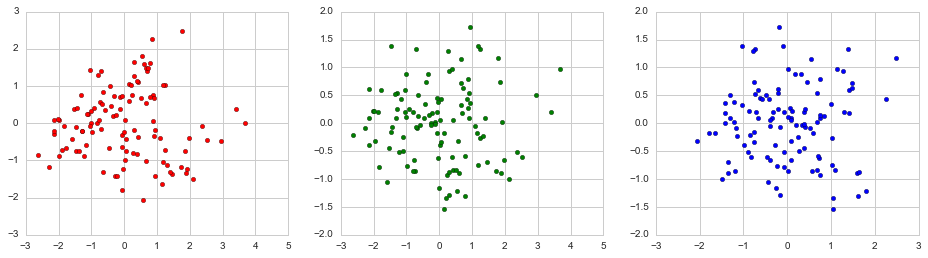

In [121]:
from statsmodels.sandbox.tools.tools_pca import pca
X = df[cols].apply(lambda x: (x - x.mean()) / x.std())
xreduced, factors, evals,evecs = pca(X)
plt.subplots(1, 3, figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.scatter(factors[:,0], factors[:,1], label='PCA0 vs PCA1', c='r') 
plt.subplot(1, 3, 2)
plt.scatter(factors[:,0], factors[:,2], label='PCA0 vs PCA2', c='g')
plt.subplot(1, 3, 3)
plt.scatter(factors[:,1], factors[:,2], label='PCA1 vs PCA2', c='b')

### `Sklearn`

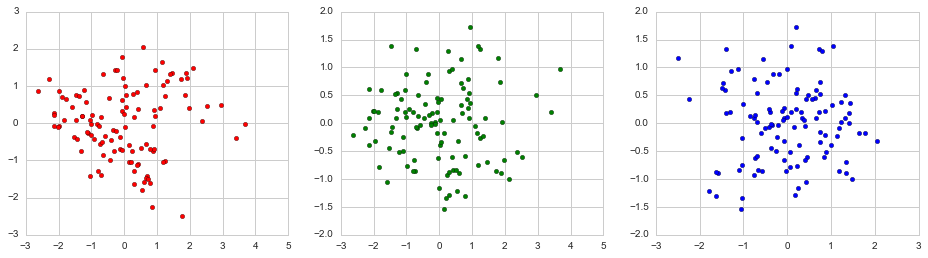

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
pc = pca.fit_transform(X)
pc1, pc2, pc3 = pc[:,0], pc[:,1], pc[:,2]
plt.subplots(1, 3, figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.scatter(pc1, pc2, label='PCA0 vs PCA1', c='r') 
plt.subplot(1, 3, 2)
plt.scatter(pc1, pc3, label='PCA0 vs PCA2', c='g')
plt.subplot(1, 3, 3)
plt.scatter(pc2, pc3, label='PCA1 vs PCA2', c='b')